## Preparation

In [2]:
#setup path
path = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
import sys; sys.path.append(path)

#standard imports
import numpy as np
import pandas as pd
import datetime

#configure display modes
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline
rcParams['figure.figsize'] = 20,6

#load data first time from database
import analysis.dataPreparer as dp
df = dp.export_dataframe(path+"analysis/output/combo.db", "thirteen_sixteen")
df_backup = df.copy()

['', 'C:\\Anaconda3\\python35.zip', 'C:\\Anaconda3\\DLLs', 'C:\\Anaconda3\\lib', 'C:\\Anaconda3', 'c:\\anaconda3\\lib\\site-packages\\setuptools-23.0.0-py3.5.egg', 'C:\\Anaconda3\\lib\\site-packages', 'C:\\Anaconda3\\lib\\site-packages\\Sphinx-1.4.1-py3.5.egg', 'C:\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\mark\\.ipython', 'C:/Users/mark/Documents/GitHub/honours/dev/package/', '']
C:\Users\mark\Documents\GitHub\honours\dev\package\config\_logger.yaml
logManager - INFO - Default log config loaded
logManager - INFO - Logger created
logManager - INFO - export_dataframe | Started
logManager - INFO - export_dataframe | Passed | 124.36


In [12]:
#reload data from memory
df = df_backup

## Data Exploration

In [5]:
df.describe()

,confidence_context_industry_category_main_dummy_advertising,confidence_context_industry_category_main_dummy_biotech,confidence_context_industry_category_main_dummy_consulting,confidence_context_industry_category_main_dummy_ecommerce,confidence_context_industry_category_main_dummy_enterprise,confidence_context_industry_category_main_dummy_games_video,confidence_context_industry_category_main_dummy_mobile,confidence_context_industry_category_main_dummy_other,confidence_context_industry_category_main_dummy_software,confidence_context_industry_category_main_dummy_web,...,potential_structural_patents_cited_by_average_number,potential_structural_patents_cited_by_total_number,potential_structural_patents_count_number,keys_company_stage_seed,keys_company_stage_series-a,keys_company_stage_series-b,keys_company_stage_series-c+,keys_company_stage_ipo,keys_company_stage_acquired,keys_company_stage_closed
count,85936.000000,85936.000000,85936.000000,85936.000000,85936.000000,85936.000000,85936.000000,85936.000000,85936.000000,85936.000000,...,18475.000000,18475.000000,18475.000000,30511.000000,30511.000000,30511.000000,30511.000000,180360.000000,180360.000000,180360.000000
mean,0.068446,0.050293,0.056868,0.101995,0.049176,0.085063,0.077011,0.139499,0.201126,0.170522,...,19.439178,1623.539215,123.193559,0.317820,0.235522,0.142572,0.091606,0.006093,0.050882,0.014077
std,0.252512,0.218551,0.231591,0.302643,0.216237,0.278977,0.266610,0.346469,0.400845,0.376093,...,40.074088,12384.548709,1088.838778,0.465637,0.424331,0.349641,0.288474,0.077822,0.219756,0.117810
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.583333,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,84.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19.000000,467.000000,34.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1017.000000,516154.000000,66401.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
#Create lifecycle stages
df["keys_company_stage_seed"] = df["confidence_validation_funding_round_codes_list_seed"]
df["keys_company_stage_series-a"] = df["confidence_validation_funding_round_codes_list_a"]
df["keys_company_stage_series-b"] = df["confidence_validation_funding_round_codes_list_b"]
df["keys_company_stage_series-c+"] = df["confidence_validation_funding_round_types_list_series-c+"]
df["keys_company_stage_ipo"] = df["confidence_performance_other_ipo_bool"]
df["keys_company_stage_acquired"] = df["confidence_performance_other_acquired_bool"]
df["keys_company_stage_closed"] = df["confidence_performance_other_closed_bool"]

def label_stage(row):
    if row["keys_company_stage_closed"] >= 1: stage = "Closed"
    elif row["keys_company_stage_acquired"] >= 1: stage = "Acquired"
    elif row["keys_company_stage_ipo"] >= 1: stage = "IPO"
    elif row["keys_company_stage_series-c+"] >= 1: stage = "Series C+"
    elif row["keys_company_stage_series-b"] >= 1: stage = "Series B"
    elif row["keys_company_stage_series-a"] >= 1: stage = "Series A"
    elif row["keys_company_stage_seed"] >= 1: stage = "Seed"
    elif row["confidence_validation_funding_rounds_number"] == 0: stage = "None"
    else: stage = "Other"
    return stage

#Create a column for None

df["keys_company_stage"] = df.apply(lambda row: label_stage(row), axis=1)
company_stage = df["keys_company_stage"]

In [119]:
pd.crosstab(company_stage, columns="keys_company_stage")

col_0,keys_company_stage
keys_company_stage,
Acquired,9177
Closed,2539
IPO,1099
None,142137
Other,10116
Seed,7277
Series A,3758
Series B,2265
Series C+,1992


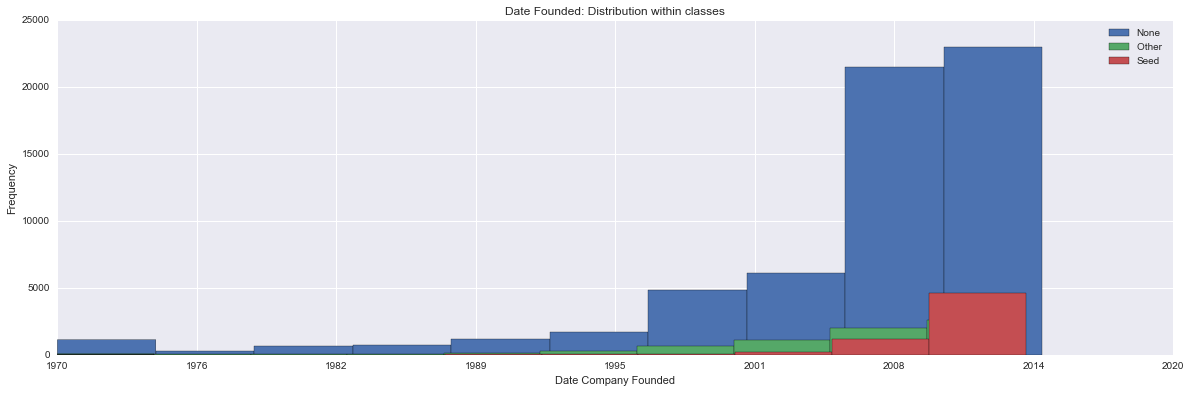

In [6]:
#Age of company
plt.figure()
fig, ax = plt.subplots()

founded_date = df["confidence_context_broader_founded_date"]
founded_date[company_stage == "None"].plot(kind='hist') 
founded_date[company_stage == "Other"].plot(kind='hist') 
founded_date[company_stage == "Seed"].plot(kind='hist') 

plt.xlim(xmin=0)
xticks = ax.get_xticks()
xlabels = [datetime.datetime.fromtimestamp(int(x)).strftime('%Y') for x in xticks]
ax.set_xticklabels(xlabels)
plt.xlabel("Date Company Founded")    
plt.title("Date Founded: Distribution within classes")
plt.legend(('None', 'Other ', 'Seed'),loc='best') 

In [14]:
from sklearn.mixture import GaussianMixture
mix = GaussianMixture(n_components=2)

def label_stage_other(row, stage):
    if row["keys_company_stage_"+stage.lower()+"_young"] == 1: val = stage + "- Young"
    elif row["keys_company_stage_"+stage.lower()+"_young"] == 0: val = stage + "- Mature"
    else: val = row["keys_company_stage"]
    return val

for stage in ["Other", "None"]:
    founded_date = df["confidence_context_broader_founded_date"]
    founded_date_other = founded_date.loc[df['keys_company_stage'] == stage].dropna()
    founded_date_other_stacked = np.vstack(founded_date_other)
    mix.fit(founded_date_other_stacked)
    pred = mix.predict(founded_date_other_stacked)
    max_index = list(mix.means_).index(max(mix.means_))
    if max_index == 0: pred = [0 if x==1 else 1 for x in pred]
    df["keys_company_stage_"+stage.lower()+"_young"] = pd.Series(pred, index=founded_date_other.index)
    df["keys_company_stage"] = df.apply(lambda row: label_stage_other(row, stage), axis=1)
    df["keys_company_stage_"+stage.lower()+"_mature"] = df.apply(lambda row: 1 if row["keys_company_stage"] == stage + "- Mature" else 0, axis=1)

NameError: name 'features' is not defined

In [127]:
print(df["keys_company_stage"].value_counts())

None             81112
None- Young      46456
None- Mature     14569
Acquired          9177
Seed              7277
Other- Young      5071
Series A          3758
Other             3213
Closed            2539
Series B          2265
Series C+         1992
Other- Mature     1832
IPO               1099
Name: keys_company_stage, dtype: int64


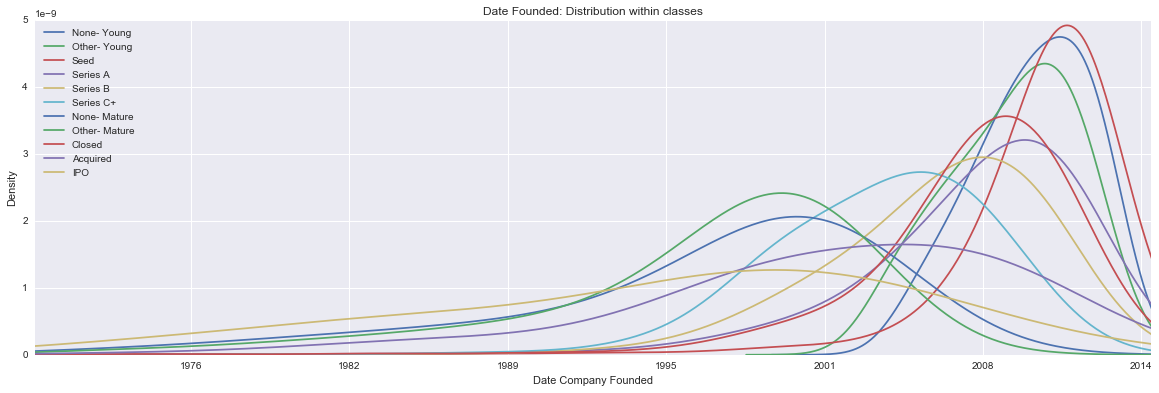

In [15]:
#Age of company
plt.figure()
fig, ax = plt.subplots()


founded_date = df["confidence_context_broader_founded_date"]
company_stage = df["keys_company_stage"]

founded_date.replace(0, np.nan, inplace=True)

#founded_date[company_stage == "Other"].plot(kind='kde') 
#stages = list(df["keys_company_stage"].value_counts().index)
#stages = ["None- Mature", "Other- Mature", "None- Young", "Other- Young", "Seed"]
stages = ["None- Young", "Other- Young", 
        "Seed", "Series A", "Series B", "Series C+",
        "None- Mature", "Other- Mature", 
        "Closed", "Acquired", "IPO"]
for stage in stages:
    try: founded_date[company_stage == stage].plot(kind='kde',bw_method=0.5) 
    except: pass
founded_date.plot(kind='kde',bw_method=0.5)

ax.set_xlim(min(founded_date),max(founded_date))
xticks = ax.get_xticks()
xlabels = [datetime.datetime.fromtimestamp(int(x)).strftime('%Y') for x in xticks]
ax.set_xticklabels(xlabels)
plt.xlabel("Date Company Founded")    
plt.title("Date Founded: Distribution within classes")
plt.legend(stages,loc='best') 

TypeError: boxplot() got an unexpected keyword argument 'split'

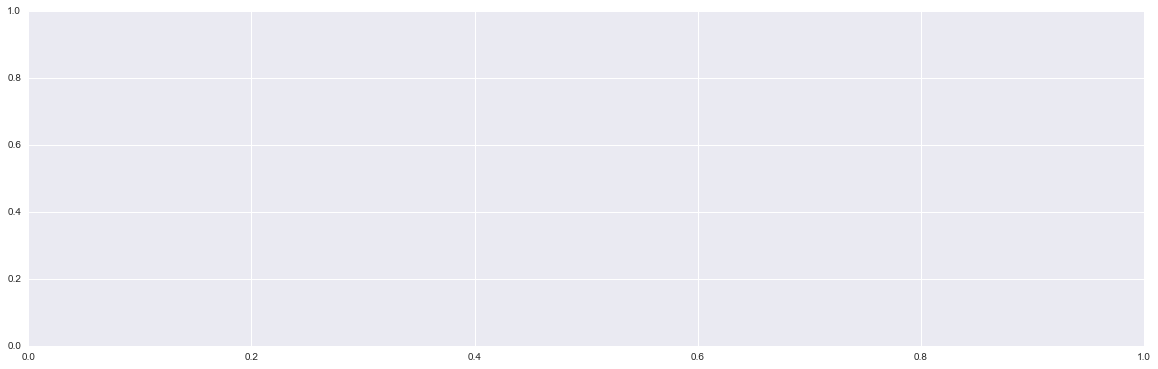

In [16]:
#plot number of funding rounds x stage
stages = ["Seed", "Series A", "Series B", "Series C+", "IPO", "Acquired", "Closed"]
sns.boxplot(
    y="keys_company_stage", order=stages,
    x="confidence_validation_funding_rounds_number", 
    hue="outcome_exit_bool", split=True, data=df)
plt.xlim(0,)



#confidence_context_broader_founded_date
#confidence_validation_funding_current_valuation_number
#confidence_validation_funding_raised_total_value_number
#confidence_validation_funding_rounds_number
#confidence_validation_funding_last_date

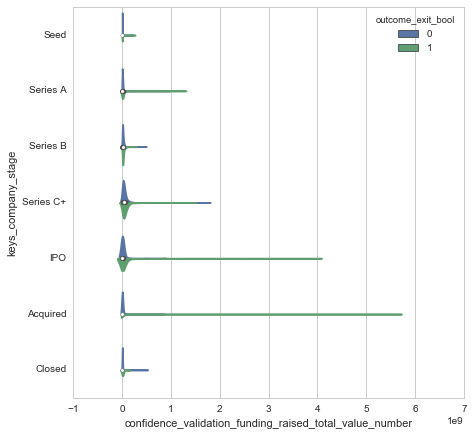

In [93]:
#plot number of funding rounds x stage
stages = ["Seed", "Series A", "Series B", "Series C+", "IPO", "Acquired", "Closed"]
f, ax = plt.subplots(figsize=(7, 7))
sns.violinplot(
    y="keys_company_stage", order=stages,
    x="confidence_validation_funding_raised_total_value_number", 
    hue="outcome_exit_bool", split=True, ax=ax, data=df)

In [241]:
df["outcome_funding_more_rounds_number"] = df["outcome_funding_rounds_number"] - df["confidence_validation_funding_rounds_number"]
df["outcome_funding_more_rounds_bool"] = df["outcome_funding_more_rounds_number"].apply(lambda x: 1 if x > 0 else 0)

df = df.loc[df['outcome_funding_more_rounds_number'] >= 0]

In [242]:
df = df.loc[df['confidence_performance_other_operating_bool'] == 1]

pd.crosstab(
    columns=df["outcome_exit_bool"], 
    index= df["keys_company_stage"],
    margins=True, normalize="index")

outcome_exit_bool,0,1
keys_company_stage,,
None,0.957774,0.042226
None- Mature,0.936440,0.063560
None- Young,0.984329,0.015671
Other,0.915826,0.084174
Other- Mature,0.839956,0.160044
Other- Young,0.931339,0.068661
Seed,0.942558,0.057442
Series A,0.875306,0.124694
Series B,0.828338,0.171662


In [153]:
df = df.loc[df['confidence_performance_other_operating_bool'] == 1]

pd.crosstab(
    columns=df["outcome_closed_bool"], 
    index= df["keys_company_stage"],
    margins=True)

outcome_closed_bool,0,1,All
keys_company_stage,,,
None,80755,357,81112
None- Mature,14505,64,14569
None- Young,45692,764,46456
Other,3063,109,3172
Other- Mature,1769,43,1812
Other- Young,4747,234,4981
Seed,6630,438,7068
Series A,3528,153,3681
Series B,2107,95,2202


In [155]:
pd.crosstab(
    columns=df["outcome_funding_more_rounds_bool"], 
    index= df["keys_company_stage"],
    margins=True)

outcome_funding_more_rounds_bool,0,1,All
keys_company_stage,,,
None,77180,3932,81112
None- Mature,13845,724,14569
None- Young,43354,3102,46456
Other,2289,883,3172
Other- Mature,1167,645,1812
Other- Young,3122,1859,4981
Seed,4644,2424,7068
Series A,2085,1596,3681
Series B,1052,1150,2202


In [134]:
df["outcome_funding_more_rounds_number"] = df["outcome_funding_rounds_number"] - df["confidence_validation_funding_rounds_number"]
df["outcome_funding_more_rounds_bool"] = df["outcome_funding_more_rounds_number"].apply(lambda x: 1 if x > 0 else 0)

df = df.loc[df['outcome_funding_more_rounds_number'] >= 0]

pd.crosstab(
    columns=df["outcome_funding_more_rounds_number"], 
    index= df["keys_company_stage"],
    margins=True)

outcome_funding_more_rounds_number,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,All
keys_company_stage,,,,,,,,,,,,,,,,,
None,77180,2664,763,300,118,52,17,10,6,2,0,0,0,0,0,0,81112
None- Mature,13845,539,116,50,10,5,2,1,1,0,0,0,0,0,0,0,14569
None- Young,43354,1928,686,299,108,40,26,10,2,2,1,0,0,0,0,0,46456
Other,2289,506,193,97,48,23,8,3,1,2,0,2,0,0,0,0,3172
Other- Mature,1167,335,160,65,38,23,6,8,4,3,1,2,0,0,0,0,1812
Other- Young,3122,929,497,225,112,46,33,6,5,4,0,1,0,1,0,0,4981
Seed,4644,1305,628,309,98,50,22,7,0,3,1,0,0,0,0,1,7068
Series A,2085,816,464,198,74,24,9,4,4,0,2,0,0,0,1,0,3681
Series B,1052,557,320,143,71,30,14,7,1,3,3,1,0,0,0,0,2202


In [115]:
df["outcome_funding_more_rounds_number"] = df["outcome_funding_rounds_number"] - df["confidence_validation_funding_rounds_number"]
df["outcome_funding_more_rounds_bool"] = df["outcome_funding_more_rounds_number"].apply(lambda x: 1 if x > 0 else 0)

df = df.loc[df['outcome_funding_more_rounds_number'] >= 0]

df_funded = df.loc[df['confidence_validation_funding_rounds_number'] >= 1]

pd.crosstab(
    columns=df_funded["outcome_funding_more_rounds_number"], 
    index= df_funded["keys_company_stage"],
    margins=True)

outcome_funding_more_rounds_number,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,All
keys_company_stage,,,,,,,,,,,,,,,,,
Mature,1312,381,185,78,43,28,7,8,5,3,1,2,0,0,0,0,2053
Other,2289,506,193,97,48,23,8,3,1,2,0,2,0,0,0,0,3172
Seed,4644,1305,628,309,98,50,22,7,0,3,1,0,0,0,0,1,7068
Series A,2085,816,464,198,74,24,9,4,4,0,2,0,0,0,1,0,3681
Series B,1052,557,320,143,71,30,14,7,1,3,3,1,0,0,0,0,2202
Series C+,749,494,296,172,104,57,30,13,7,4,2,1,2,0,0,0,1931
Young,2977,883,472,212,107,41,32,6,4,4,0,1,0,1,0,0,4740
All,15108,4942,2558,1209,545,253,122,48,22,19,9,7,2,1,1,1,24847


## Data Selection

In [157]:
#make constraints
df = df.loc[df['confidence_performance_other_operating_bool'] == 1]

In [158]:
#create label
label = "outcome_exit_bool"
y = df[label]

In [8]:
#create features
df = df.select_dtypes(['number'])
drops = [col for col in list(df) if col.startswith(("key","from","outcome","index"))]
X = df.drop(drops, axis=1)
features = list(X)

In [160]:
#recombine dataframe
df = pd.concat([df[features], df[label]], axis=1)

In [9]:
from collections import defaultdict
groups = defaultdict(list)

for feature in features:
    key = feature.split("_")[2]
    groups[key].append(feature)

for group in groups.values():
    df[group].describe()

## Missing Values

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


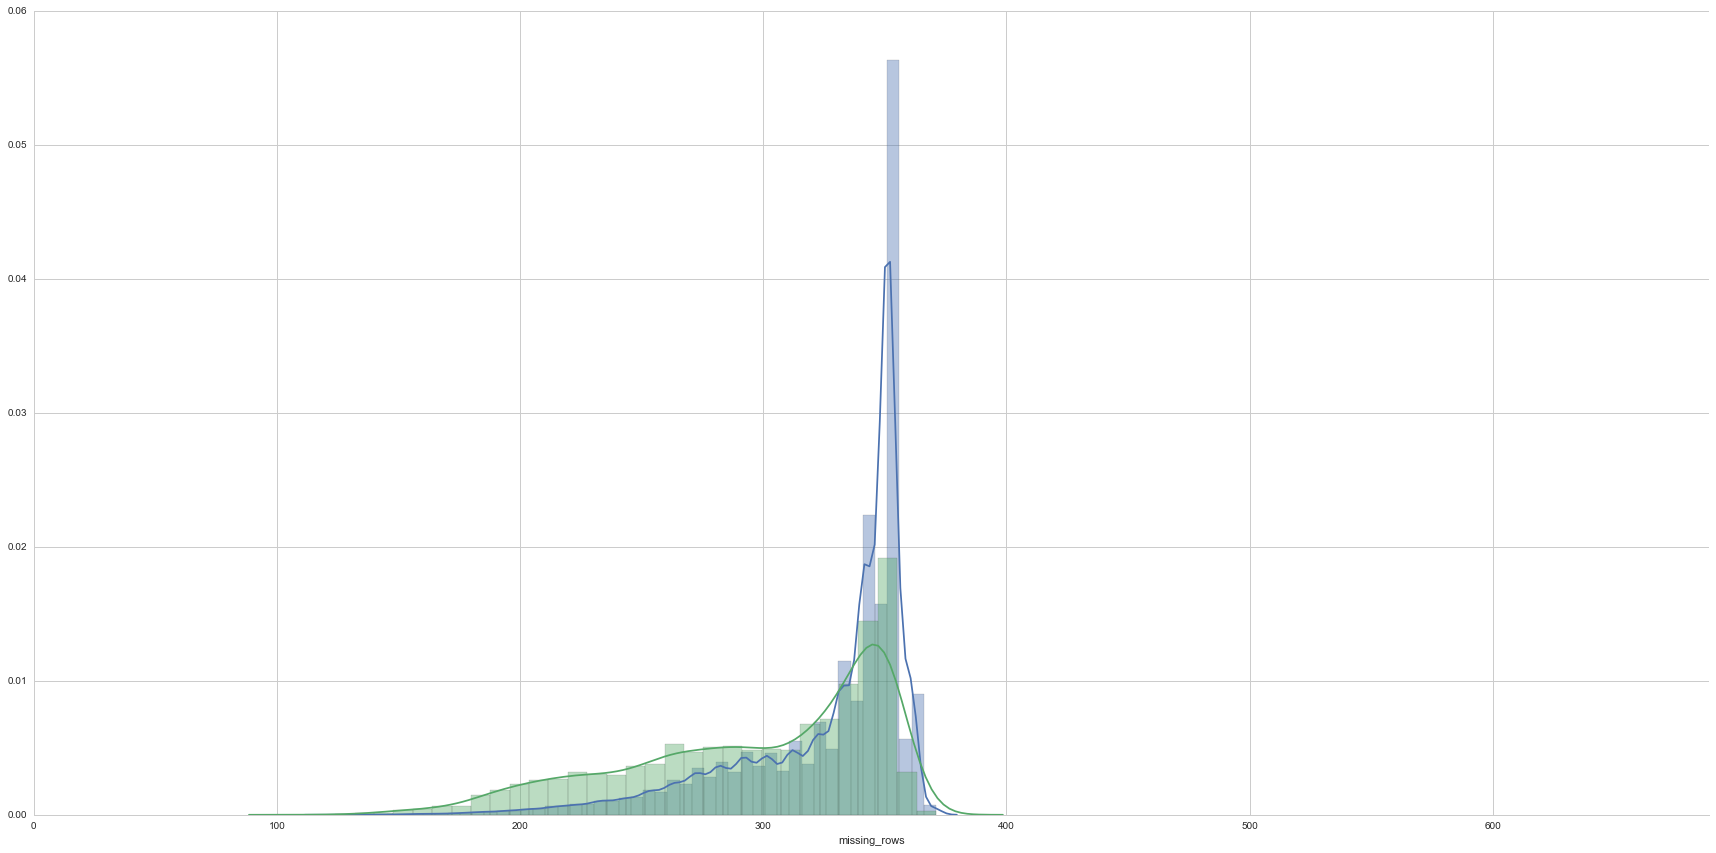

In [161]:
#plot missing values by row
missing_rows = pd.DataFrame(data = {
    'missing_rows': df.isnull().sum(axis=1), 
    label: df[label]})
g = sns.FacetGrid(
    data=missing_rows, 
    hue=label,
    xlim=(0,len(list(df))),
    size=12, aspect=2)
g.map(sns.distplot,"missing_rows")

(166984, 2) (166984, 1)


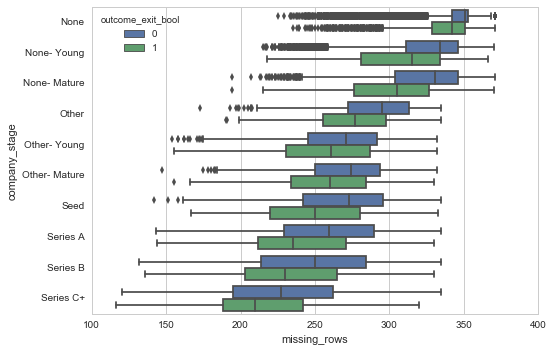

In [175]:
#company_stage = company_stage.to_frame(name="company_stage")

print(missing_rows.shape, company_stage.shape)

missing_combo = pd.concat([missing_rows, company_stage],axis=1)

stages = ["None","None- Young", "None- Mature", 
          "Other", "Other- Young", "Other- Mature",
          "Seed", "Series A", "Series B", "Series C+"]

bystage = missing_combo.groupby('company_stage')
sns.boxplot(x="missing_rows", y="company_stage", hue=label, 
            data=missing_combo,order = stages)

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(0, 166984)

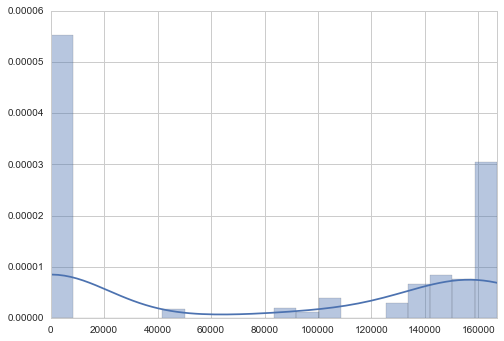

In [162]:
#plot missing values by column
missing_cols = pd.DataFrame(
    data = {'missing_cols': df.isnull().sum(axis=0)},
    index = list(df))
g = sns.distplot(missing_cols,bins=20)
g.axes.set_xlim(0,len(df.index))

In [176]:
from sklearn.preprocessing import Imputer
imp = Imputer(
    missing_values="NaN", 
    strategy="median", 
    axis=1)
X = pd.DataFrame(
    data = imp.fit_transform(X),
    columns = X.columns)
df = pd.concat([y, X],axis=1)

In [ ]:
df_backup_missing = df.copy()

## Feature Selection

In [ ]:
df = df_backup_missing

In [ ]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.2)
vt.fit(X)
vt.variances_
#g = sns.distplot(vt.variances_)
#g.axes.set_xlim(0,100)

In [177]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.2)
vt.fit(X)
X = X.iloc[:, vt.get_support()]
df = pd.concat([y, X],axis=1)

In [ ]:
df.describe()

In [232]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5),scoring="roc_auc",n_jobs=-1):

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes,scoring=scoring)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    
    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim: plt.ylim(ylim)
    plt.title(title)

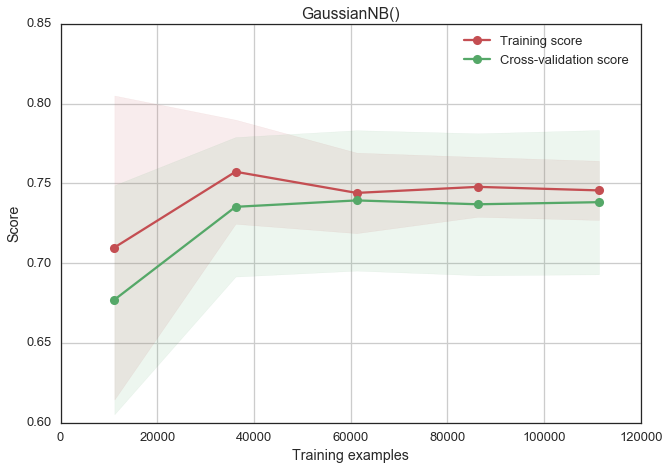

In [203]:
from sklearn.naive_bayes import GaussianNB
plot_learning_curve(GaussianNB(), "GaussianNB()", X, y)

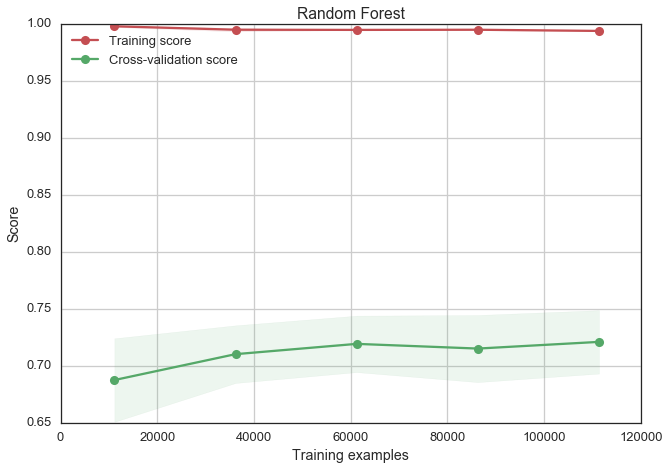

In [234]:
from sklearn.ensemble import RandomForestClassifier
plot_learning_curve(RandomForestClassifier(), "Random Forest", X, y)

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


auc: 0.5 f1: 0.0 mc: 0.0
auc: 0.524024024024 f1: 0.0916905444126 mc: 0.216050549938
auc: 0.50344525474 f1: 0.0144761904762 mc: 0.0515561955957
auc: 0.595830285296 f1: 0.321669736034 mc: 0.431003551176
auc: 0.501427332542 f1: 0.00614911606457 mc: 0.0309108966246
auc: 0.50872132853 f1: 0.0343053173242 mc: 0.127966872421
auc: 0.505553285071 f1: 0.0233082706767 mc: 0.062038169722
auc: 0.539921115548 f1: 0.147689375893 mc: 0.270771381115
auc: 0.503364566172 f1: 0.0137825421133 mc: 0.0599768067873
auc: 0.528075758025 f1: 0.106324472961 mc: 0.230461782763
auc: 0.506848730375 f1: 0.0289424860853 mc: 0.0637113480258
auc: 0.557046081984 f1: 0.203799654577 mc: 0.316982859152
auc: 0.505897715816 f1: 0.0241965973535 mc: 0.0731909916229
auc: 0.563039752303 f1: 0.223404255319 mc: 0.342953655339
auc: 0.508643430617 f1: 0.0351139335077 mc: 0.0876071050303
auc: 0.60980704392 f1: 0.359771573604 mc: 0.459111803627
auc: 0.509649726408 f1: 0.0388349514563 mc: 0.0973020156252
auc: 0.628485788858 f1: 0.408531

NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

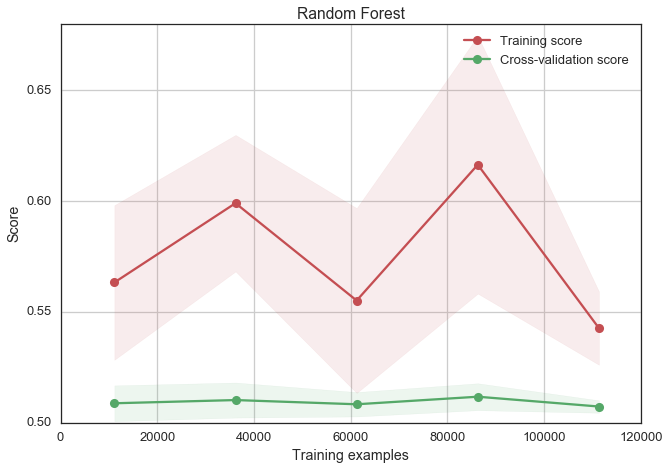

In [228]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

from scipy.stats import randint as sp_randint
param_dist = {
    "max_depth": [25],
    "max_features": [3, "auto","sqrt","log2", None],
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"], 
    "n_jobs": [-1]}

#setup scorer
from sklearn import metrics

def scorer(y_true, y_pred, **kwargs):
    mc = metrics.matthews_corrcoef(y_true, y_pred)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    print("auc:", roc_auc, "f1:", f1, "mc:", mc)
    return roc_auc

auc_scorer = metrics.make_scorer(scorer)

# run randomized search
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(rf, n_iter=3, 
    param_distributions=param_dist,return_train_score=False)
plot_learning_curve(random_search, "Random Forest", X, y,scoring=auc_scorer)

# Feature importances
rf.set_params(**random_search.best_params_)
rf.fit(X, y)
zipped = list(zip(list(X), rf.feature_importances_))
zipped.sort(key = lambda t: t[1],reverse=True)
print('Feature Importances (Top 20):')
for i, j in zipped[:20]: print("{}: {:.4f}".format(i, j))

In [ ]:
#----------ALGORITHM COMPARISON----------#

#Setup pre-processors

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.naive_bayes import GaussianNB

pipe = Pipeline(steps=[
    ("imputer", Imputer()),
    ("scaler", StandardScaler()),
    ("thresholder", VarianceThreshold()),
    ("extracter", SelectKBest()),
    ("clf", GaussianNB())
])

#Setup classifiers

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

CLASSIFIERS = [
    ("Naive Bayes", GaussianNB()),
    ("Logistic Regression", LogisticRegression(C=1e5)),
    ("K-Nearest Neighbours", KNeighborsClassifier(3)),
    ("Decision Tree", DecisionTreeClassifier(max_depth=5)),
    ("Random Forest", RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)),
    ("Linear SVM", SVC(kernel="linear", C=0.025)),
    ("RBF SVM", SVC(gamma=2, C=1)),
    ("Neural Net", MLPClassifier(alpha=1))
]

#Setup scorer
from sklearn import metrics

def scorer(y_true, y_pred, **kwargs):
    mc = metrics.matthews_corrcoef(y_true, y_pred)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    print("mc:", mc, "auc:", roc_auc, "f1:", f1)
    return mc

mc_scorer = metrics.make_scorer(scorer)

#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = [
    dict(
        clf = [GaussianNB()]
    ),
    dict(
        clf = [LogisticRegression()], 
        clf__C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    ),
    dict(
        clf = [KNeighborsClassifier()], 
        clf__weights = ['uniform','distance'],
        clf__n_neighbors = [5,6,7,8,9,10]
    ),
    dict(
        clf = [DecisionTreeClassifier()],
        clf__criterion = ["gini", "entropy"],
        clf__max_depth = [5, 10],
        clf__class_weight = [None, "balanced"]
    ),
    dict(
        clf = [RandomForestClassifier()], 
        clf__n_estimators = [5],
        clf__criterion = ["gini", "entropy"],
        clf__max_depth = [5, 10],
        clf__class_weight = [None, "balanced"]
    ),
    dict(
        clf = [SVC()],
        clf__kernel = ["linear", "rbf", "poly", "sigmoid"],
        clf__C = [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    ),
]

#Run comparison

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score,cross_val_predict

#Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

#Grid search and fit
clf = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring = mc_scorer, verbose=2, return_train_score=False)
clf.fit(X_train, y_train)
params = clf.best_params_

for name, clf in CLASSIFIERS:
    print('Classifier Type:', name)
    pipe = make_pipeline(*PREPROCESSORS, clf)
    scores = cross_val_score(pipe, X, y, cv=3, scoring=mc_scorer,verbose=1)
    print('CV Scores (Matthews CC):', scores)
    print("CV Avg (Matthews CC): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print('-'*20, '\n')

In [ ]:
from sklearn.linear_model import RandomizedLasso
 
rlasso = RandomizedLasso(alpha=0.025)
rlasso.fit(X, y)
 
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 features), reverse=True))

LinAlgError: SVD did not converge

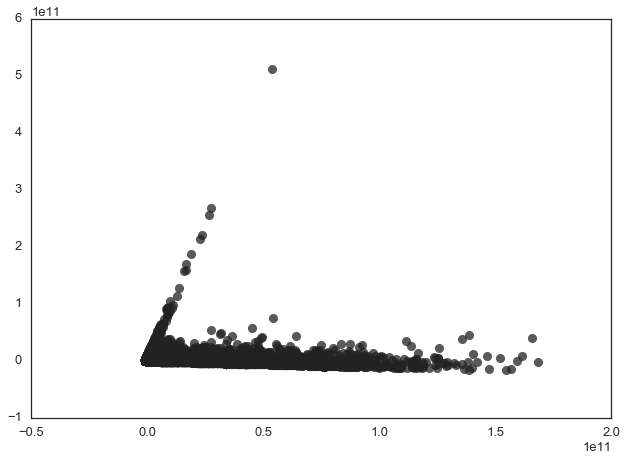

In [193]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

tmp = np.array(X) #df is a Pandas DataFrame
proj = pca.fit_transform(tmp)

pca_0 = pd.DataFrame(data=proj[:,0], index=X.index, columns = ["pca_0"])
pca_1 = pd.DataFrame(data=proj[:,1], index=X.index, columns = ["pca_1"])

combo = pd.concat([pca_0, pca_1, y],axis=1)

sns.interactplot(data=combo, x1="pca_0",x2="pca_1",y=label)
#plt.scatter(proj[:,0], proj[:,1], color=label)
#g.plot_marginals(sns.distplot, kde=False, color=".7", bins=30)
#g.plot_joint(plt.scatter, color=".5", edgecolor="none", alpha=1)
#g.set_axis_labels(xlabel='PC1', ylabel='PC2')


In [235]:
sorted(list(features))

['confidence_context_broader_founded_date',
 'confidence_context_broader_offices_country_list_aus',
 'confidence_context_broader_offices_country_list_can',
 'confidence_context_broader_offices_country_list_deu',
 'confidence_context_broader_offices_country_list_esp',
 'confidence_context_broader_offices_country_list_fra',
 'confidence_context_broader_offices_country_list_gbr',
 'confidence_context_broader_offices_country_list_ind',
 'confidence_context_broader_offices_country_list_irl',
 'confidence_context_broader_offices_country_list_isr',
 'confidence_context_broader_offices_country_list_usa',
 'confidence_context_broader_offices_headquarters_country_dummy_aus',
 'confidence_context_broader_offices_headquarters_country_dummy_can',
 'confidence_context_broader_offices_headquarters_country_dummy_deu',
 'confidence_context_broader_offices_headquarters_country_dummy_esp',
 'confidence_context_broader_offices_headquarters_country_dummy_fra',
 'confidence_context_broader_offices_headquart

In [238]:
df = df_backup

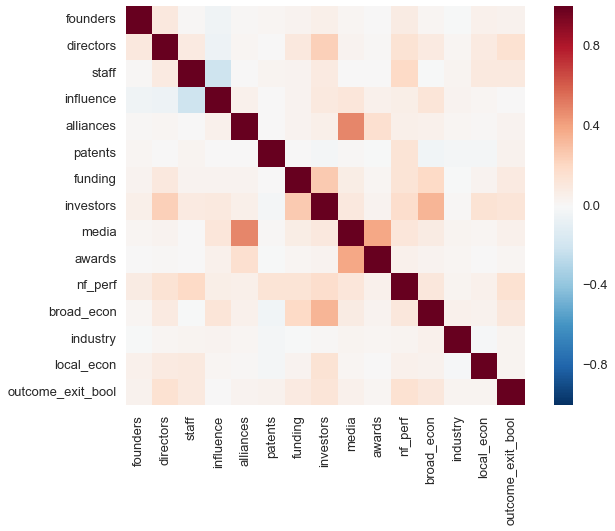

In [251]:
features_list = [
    ("founders", "potential_human_founders_companies_operating_director_average_number"),
    ("directors","potential_human_directors_companies_exits_all_average_number"),
    ("staff","potential_human_staff_jobs_all_average_number"),
    ("influence","potential_social_influence_twitter_bool"),
    ("alliances","potential_social_alliances_milestones_count_alliance_number"),
    ("patents","potential_structural_patents_count_number"),
    ("funding","confidence_validation_funding_raised_total_value_number"),
    ("investors","confidence_validation_investors_count_funded_exit_total_max_number"),
    ("media","confidence_validation_media_milestones_count_all_number"),
    ("awards","confidence_validation_awards_milestones_count_awards_number"),
    ("nf_perf","confidence_performance_other_staff_all_total_number"),
    ("broad_econ","confidence_economy_broader_confidence_validation_funding_first_date_SP500_number"),
    ("industry","confidence_context_industry_category_main_dummy_software"),
    ("local_econ","confidence_context_local_offices_headquarters_state_dummy_ca")
]

features = df[[v for k,v in features_list]]
features.columns = [k for k,v in features_list]
df_small = pd.concat([features, df[label]], axis=1)

sns.heatmap(df_small.corr(method="pearson"), square=True)
#sns.pairplot(df_small, hue=label,dropna=True)
sns.plt.show()

In [255]:
imp = Imputer(
    missing_values="NaN", 
    strategy="median", 
    axis=1)
X = features
X = pd.DataFrame(
    data = imp.fit_transform(X),
    columns = X.columns)
y = df[label]
df = pd.concat([y, X],axis=1)

array([ 0.03604656,  0.10141788,  0.1609924 ,  0.01958999,  0.00563943,
        0.18302064,  0.12838826,  0.05851192,  0.03489784,  0.00384547,
        0.0969394 ,  0.12227722,  0.02354278,  0.02489021])

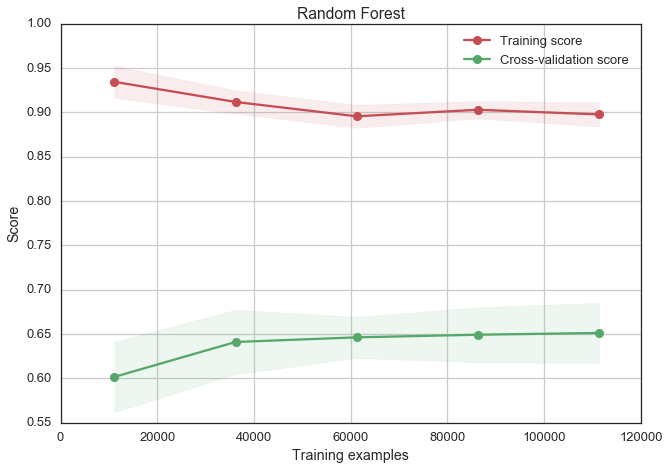

In [259]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
plot_learning_curve(rf, "Random Forest", X, y)



In [261]:
rf.fit(X, y)
zipped = list(zip(list(X), rf.feature_importances_))
zipped.sort(key = lambda t: t[1],reverse=True)
print('Feature Importances:')
for i, j in zipped[:20]: print("{}: {:.4f}".format(i, j))

Feature Importances (Top 20):
patents: 0.1756
staff: 0.1650
funding: 0.1316
broad_econ: 0.1194
nf_perf: 0.1006
directors: 0.0977
investors: 0.0605
founders: 0.0382
media: 0.0336
local_econ: 0.0258
industry: 0.0241
influence: 0.0182
alliances: 0.0061
awards: 0.0036
